# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

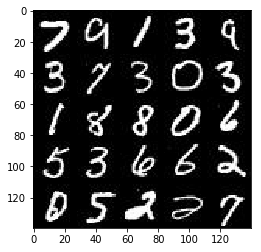

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

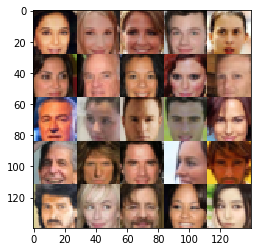

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #Create Placeholders of input images, Z and learning rate
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        #alpha is the param for leaky relu
        alpha=0.2
        
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * n1, n1)
        #16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * n2, n2)
        #8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * n3, n3)
        #4x4x512

        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha=0.1
    with tf.variable_scope('generator', reuse = reuse):
        #Fully connected layer
        x1 = tf.layers.dense(z,  7 * 7 * 512)
        #Reshape the fully connected layer to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9,
    #using the parameter smooth. Typically used with classifiers to improve performance.
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8370... Generator Loss: 0.1309
Epoch 1/2... Discriminator Loss: 2.1529... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 3.1891... Generator Loss: 0.1593
Epoch 1/2... Discriminator Loss: 2.8531... Generator Loss: 0.2125
Epoch 1/2... Discriminator Loss: 2.5008... Generator Loss: 0.3697
Epoch 1/2... Discriminator Loss: 2.4296... Generator Loss: 0.2517
Epoch 1/2... Discriminator Loss: 2.1568... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 2.1411... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 1.9889... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.7596


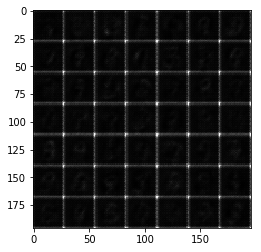

Epoch 1/2... Discriminator Loss: 1.6808... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.9244... Generator Loss: 0.3126
Epoch 1/2... Discriminator Loss: 1.8469... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.8308... Generator Loss: 0.3201
Epoch 1/2... Discriminator Loss: 1.6791... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 1.5164... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.8208


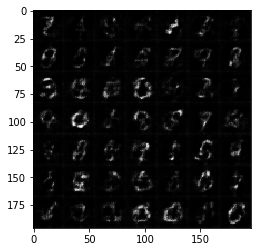

Epoch 1/2... Discriminator Loss: 1.6824... Generator Loss: 0.3582
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.7663... Generator Loss: 0.3411
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.7633... Generator Loss: 0.3428
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.6162... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.8257


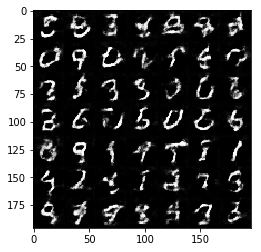

Epoch 1/2... Discriminator Loss: 1.6045... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.6484... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 1.6153... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 1.7220... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.6666... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 0.5222


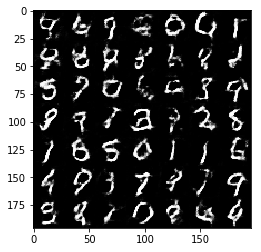

Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 1.7706... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.5200... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 0.4278
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 1.0783


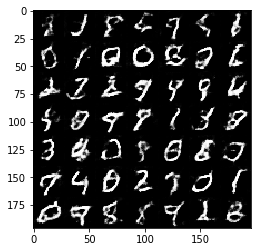

Epoch 1/2... Discriminator Loss: 1.5688... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.6557... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.5368... Generator Loss: 0.4976


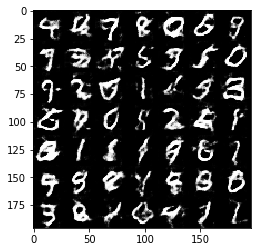

Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.9243
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.6325... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.5399... Generator Loss: 0.4797
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 0.4649


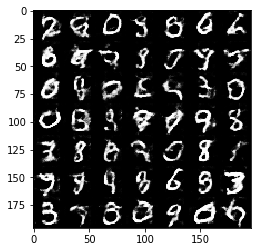

Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.5885... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.6870... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.4969


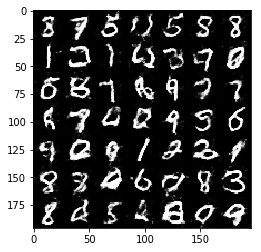

Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.5410... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 0.3562
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.9337
Epoch 1/2... Discriminator Loss: 1.5848... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.4742


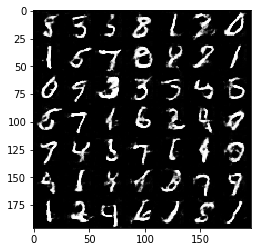

Epoch 1/2... Discriminator Loss: 1.6158... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.4417
Epoch 2/2... Discriminator Loss: 1.5723... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 1.4829... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.5847... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.5041... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.5905... Generator Loss: 0.5089
Epoch 2/2... Discriminator Loss: 1.5708... Generator Loss: 0.7075


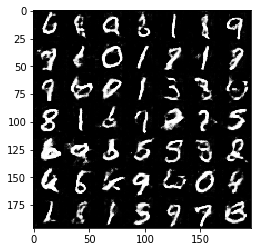

Epoch 2/2... Discriminator Loss: 1.4986... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.5012... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.5546
Epoch 2/2... Discriminator Loss: 1.6030... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.8308... Generator Loss: 0.3165
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.6461... Generator Loss: 0.5716


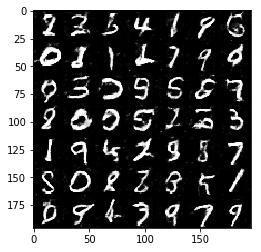

Epoch 2/2... Discriminator Loss: 1.6050... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.4833... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.6320... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.6329... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 1.4676... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.6285... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.5277... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 1.0093


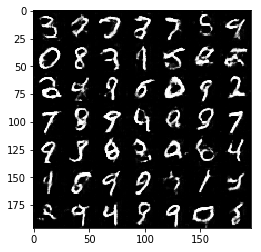

Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.5986... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.5618... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.5336... Generator Loss: 0.4887


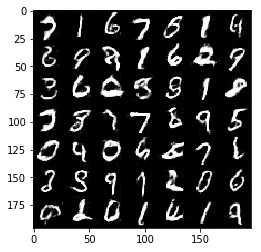

Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.5637... Generator Loss: 0.5106
Epoch 2/2... Discriminator Loss: 1.5121... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.4867... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.7267... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 1.6096... Generator Loss: 0.4531
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 0.7601


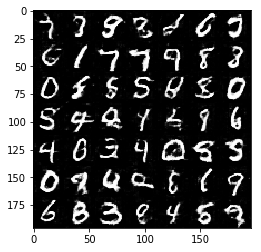

Epoch 2/2... Discriminator Loss: 1.5720... Generator Loss: 1.0885
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.6171... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.4523... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.5745... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.6986... Generator Loss: 0.5042
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.8421


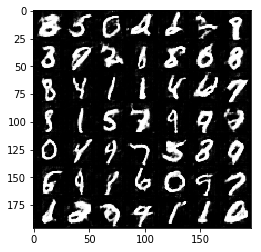

Epoch 2/2... Discriminator Loss: 1.5478... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.5644... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.5082... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.5920... Generator Loss: 0.5357
Epoch 2/2... Discriminator Loss: 1.5279... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 1.5739... Generator Loss: 0.6124


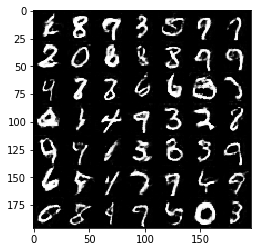

Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.6177... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 1.5991... Generator Loss: 0.3935
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.5431... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.8410


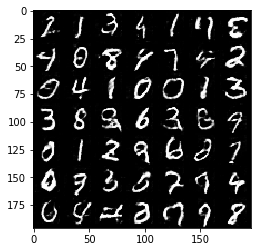

Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.6846... Generator Loss: 0.3573
Epoch 2/2... Discriminator Loss: 1.5254... Generator Loss: 0.5201
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.5730... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 1.5149... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.6842


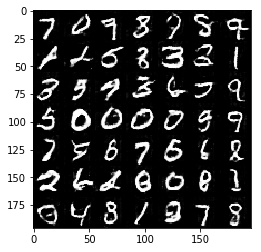

Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.7424... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 1.4902... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.6790... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.5238


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Starting to generate numbers at the earlier stage.
Generator loss is becoming smaller than dicriminator loss in the early stage in epoch 1.
Successufly generating numbers by DCGAN.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 3.2414
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 4.4269... Generator Loss: 0.0514
Epoch 1/1... Discriminator Loss: 3.0966... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 2.4232
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 2.8491... Generator Loss: 0.1079
Epoch 1/1... Discriminator Loss: 1.9207... Generator Loss: 0.3027
Epoch 1/1... Discriminator Loss: 1.9202... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.8049... Generator Loss: 0.4317


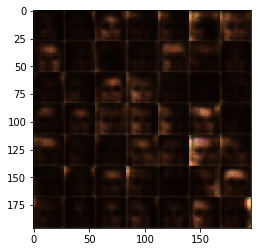

Epoch 1/1... Discriminator Loss: 2.0777... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 1.8480... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.9182... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.8857... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 2.0796... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.9062... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.9121... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 0.5561


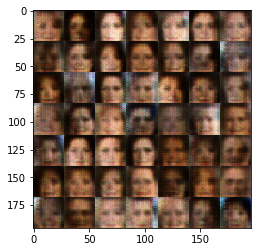

Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 0.5162


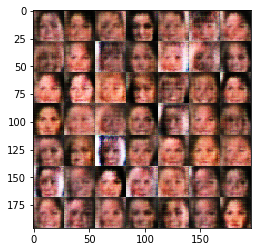

Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.7714... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.5559


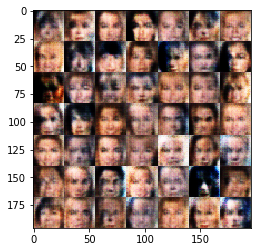

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.8253


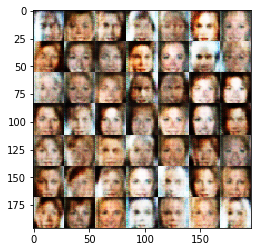

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6656


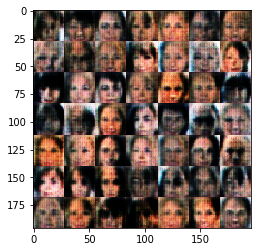

Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.7664... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.5504


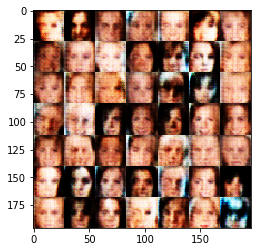

Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6680


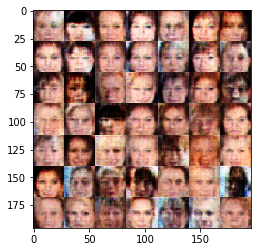

Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8079


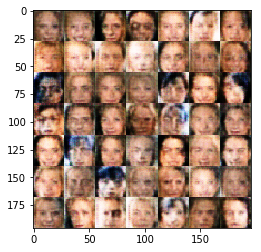

Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6789


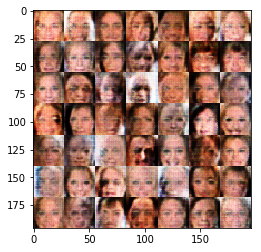

Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.7492... Generator Loss: 0.4637


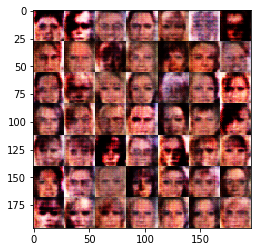

Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6820


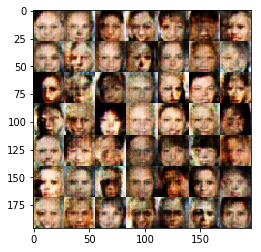

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7858


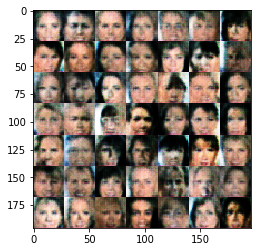

Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6729


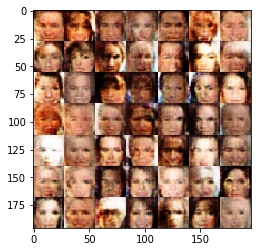

Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.9046


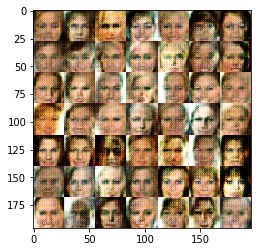

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.8761


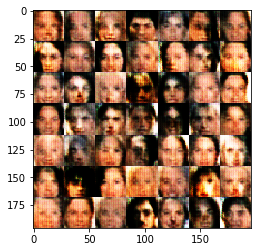

Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 1.5160
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8554


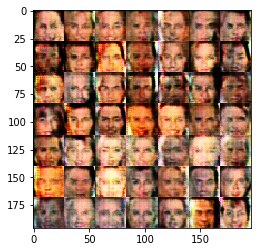

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.8002


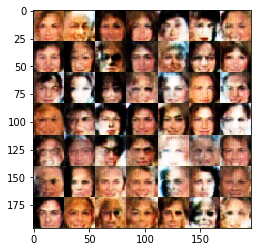

Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 0.6952


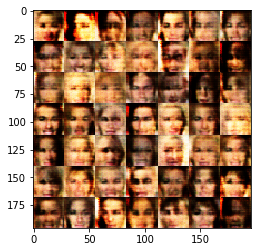

Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7139


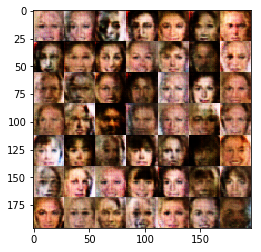

Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7879


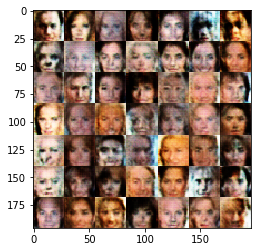

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6695


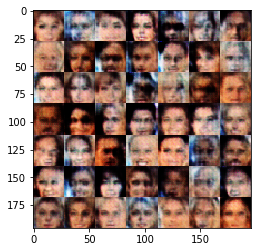

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7623


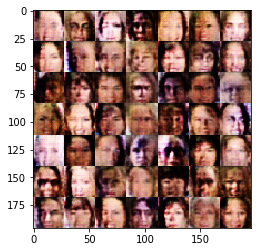

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7939


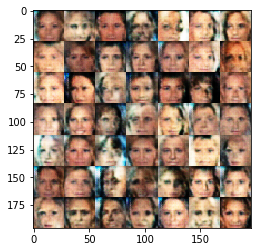

Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.8042


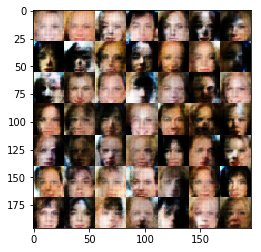

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5902


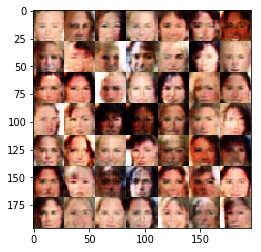

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.7521


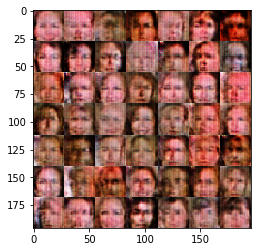

Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.8663


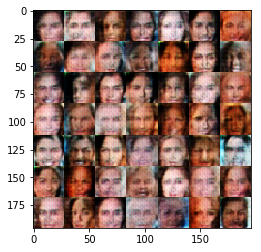

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.9435


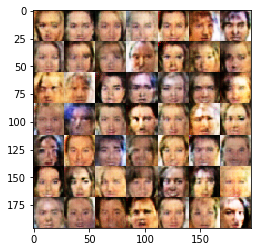

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6969


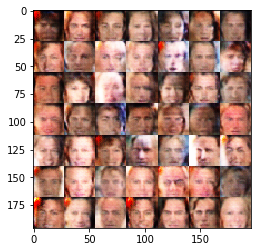

Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7018


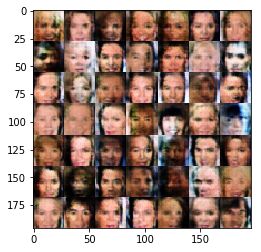

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7907


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0009
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Successfully generating faces, and generator loss is getting lower and smaller than the discrimator's loss.
I used the lower values in learning rate and beta1 than the Adam's default(recommended) numbers. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.